# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 1.환경설정

### (1) 경로 설정

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

In [1]:
!pip install -r requirements.txt

  Using cached numpy-1.22.4.zip (11.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached xgboost-1.7.5-py3-none-win_amd64.whl (70.9 MB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    The user requested numpy==1.22.4
    pandas 1.5.3 depends on numpy>=1.21.0; python_version >= "3.10"
    pandas 1.5.3 depends on numpy>=1.23.2; python_version >= "3.11"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict



ERROR: Cannot install numpy==1.22.4 and pandas==1.5.3 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


#### 2) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [3]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [4]:
# read_csv를 활용
taxi=pd.read_csv(file1)
weather=pd.read_csv(file2)

In [5]:
# to_datetime 활용, '기준일' 컬럼 타입 변경  
taxi['기준일']=pd.to_datetime(taxi['기준일'])
weather['Date']=pd.to_datetime(weather['Date'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4018 non-null   datetime64[ns]
 1   temp_max         4018 non-null   float64       
 2   temp_min         4018 non-null   float64       
 3   rain(mm)         4018 non-null   float64       
 4   humidity_max(%)  4018 non-null   float64       
 5   humidity_min(%)  4018 non-null   float64       
 6   sunshine(MJ/m2)  4018 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.9 KB


In [6]:
#내일의 날씨(예보)를 기반으로 내일의 waiting_time_mean 예측이므로! 
weather=weather.set_index('Date').shift(-1)
weather

,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
Date,,,,,,
2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
2012-01-05,1.3,-4.8,0.0,55.0,27.0,8.57
...,...,...,...,...,...,...
2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84


#### 2) 기본 정보 조회

In [7]:
#전체 데이터의 행,열 개수 확인
print("taxi_shape :",taxi.shape)
print("weather_shape",weather.shape)

taxi_shape : (2922, 7)
weather_shape (4018, 6)


In [8]:
#전체 데이터의 모든 변수 확인
print("taxi_columns:",taxi.columns)
print("weather_columns \n: ",weather.columns)

taxi_columns: Index(['기준일', '차량운행', '접수건', '탑승건', '평균대기시간', '평균요금', '평균승차거리'], dtype='object')
weather_columns 
:  Index(['temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)',
       'humidity_min(%)', 'sunshine(MJ/m2)'],
      dtype='object')


#### 3) 칼럼이름을 영어로 변경


In [9]:
eng_columns=['Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance' ]
taxi.columns=eng_columns

### 데이터 merge
- 데이터를 다루기 쉽게 하나의 df로 미리 합치기

In [10]:
df = pd.merge(taxi,weather, on='Date', how='inner')

## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [19]:
# dt.weekday, dt.month, dt.week, dt.year 활용
df=df.set_index('Date')
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['week'] = df.index.week
df['year'] = df.index.year
df.head().T

C:\Users\user\AppData\Local\Temp\ipykernel_18704\522442224.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


Date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05
car_cnt,213.00,420.00,209.00,196.00,421.00
request_cnt,1023.00,3158.00,1648.00,1646.00,4250.00
ride_cnt,924.00,2839.00,1514.00,1526.00,3730.00
waiting_time,23.20,17.20,26.20,24.50,26.20
fare,2427.00,2216.00,2377.00,2431.00,2214.00
distance,10764.00,8611.00,10198.00,10955.00,8663.00
temp_max,-2.00,2.40,8.20,7.90,4.10
temp_min,-8.90,-9.20,0.20,-0.90,-7.40
rain(mm),0.00,0.00,0.00,0.00,3.40
humidity_max(%),63.00,73.00,89.00,95.00,98.00


### (2) 일별 (lineplot 활용)

* 차량 운행수

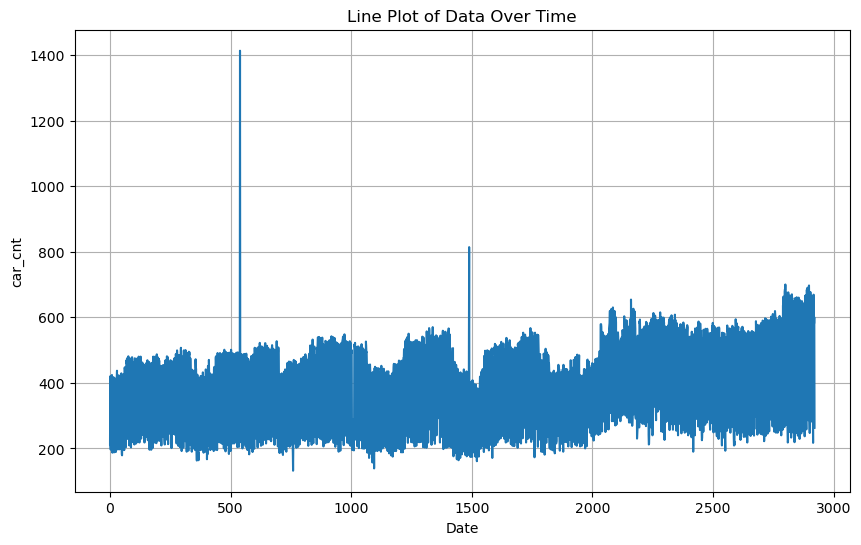

In [11]:
plt.figure(figsize=(10, 6))  # 그래프 크기 설정 (optional)

# 데이터프레임의 'column_name' 열을 기반으로 line plot 그리기
plt.plot(df.index, df['car_cnt'], linestyle='-')

# 그래프에 제목 추가 (optional)
plt.title('Line Plot of Data Over Time')

# x축과 y축 레이블 추가 (optional)
plt.xlabel('Date')
plt.ylabel('car_cnt')

plt.grid(True)  # 그리드 표시 (optional)

plt.show()  # 그래프 표시

* 접수건, 탑승건

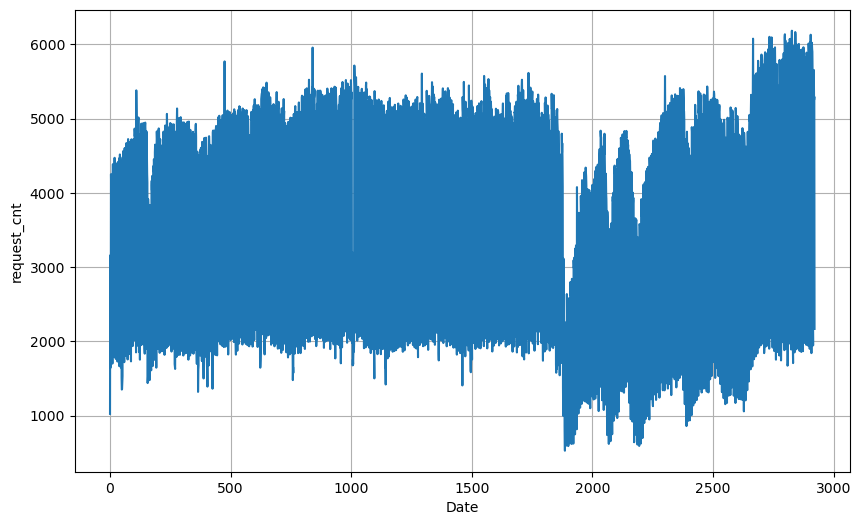

In [12]:
#접수건
plt.figure(figsize=(10, 6)) 
plt.plot(df.index, df['request_cnt'], linestyle='-')

plt.xlabel('Date')
plt.ylabel('request_cnt')

plt.grid(True)  
plt.show()  

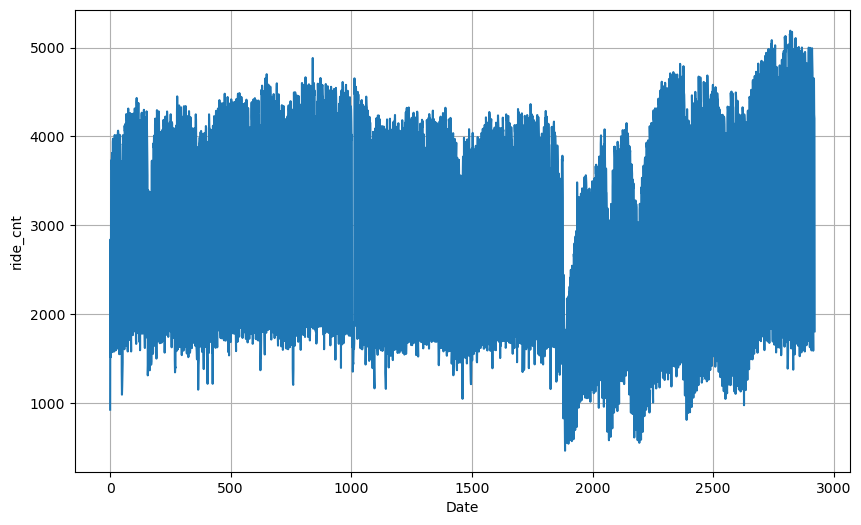

In [13]:
#탑승건
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['ride_cnt'], linestyle='-')

plt.xlabel('Date')
plt.ylabel('ride_cnt')

plt.grid(True) 
plt.show() 

* 대기시간

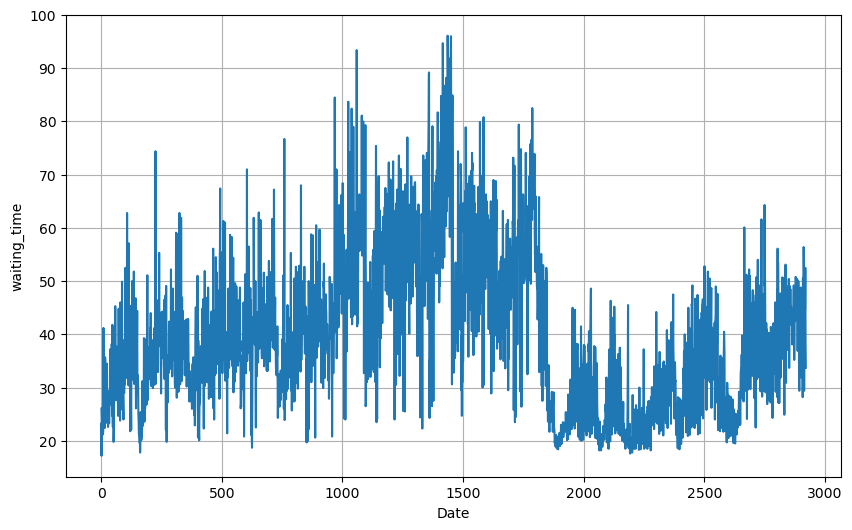

In [14]:
#대기시간
plt.figure(figsize=(10, 6)) 
plt.plot(df.index, df['waiting_time'], linestyle='-')

plt.xlabel('Date')
plt.ylabel('waiting_time')

plt.grid(True)

plt.show() 

* 운임

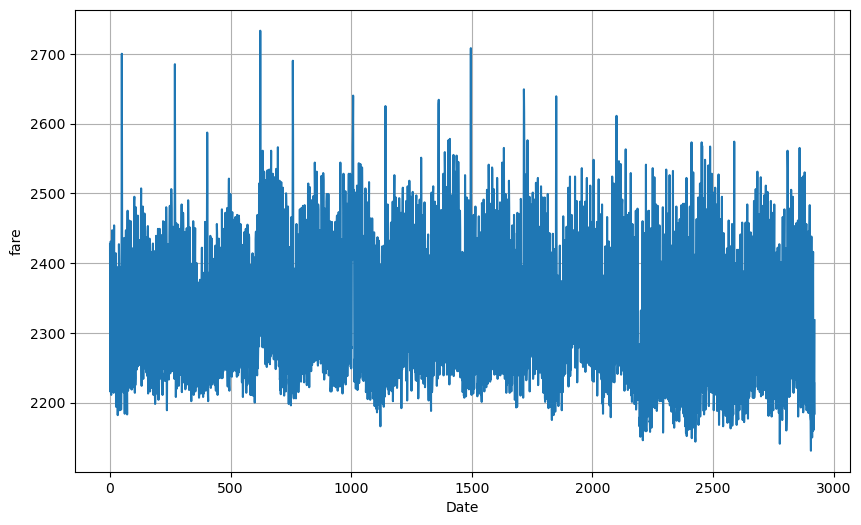

In [15]:
#운임
plt.figure(figsize=(10, 6)) 
plt.plot(df.index, df['fare'], linestyle='-')

plt.xlabel('Date')
plt.ylabel('fare')

plt.grid(True)  # 그리드 표시 (optional)
plt.show()  # 그래프 표시

* 이동거리

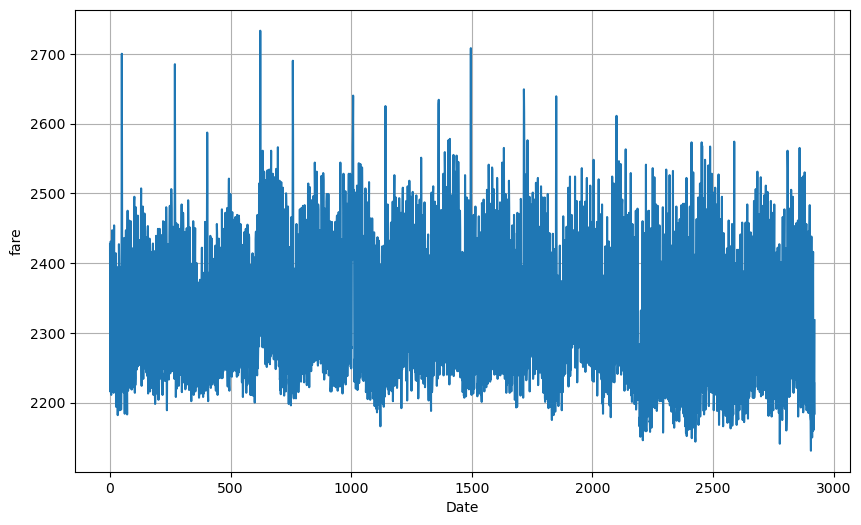

In [16]:
#이동거리
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['fare'], linestyle='-')
#plt.title('Line Plot of Data Over Time')

plt.xlabel('Date')
plt.ylabel('fare')

plt.grid(True)

plt.show()

### (3) 요일별 (boxplot활용)

* 차량 운행수

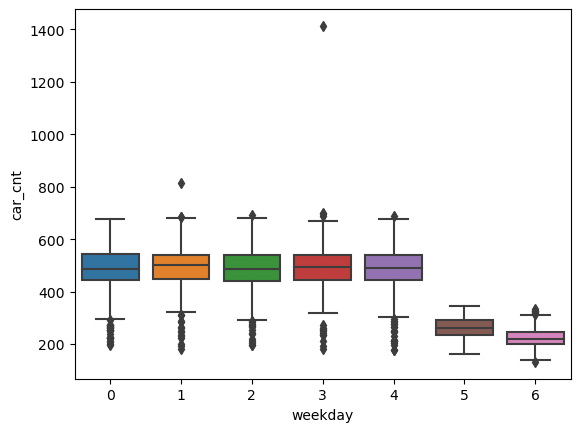

In [20]:
#차량운행수
sns.boxplot(x="weekday", y="car_cnt", data=df)
plt.show()

* 접수건, 탑승건

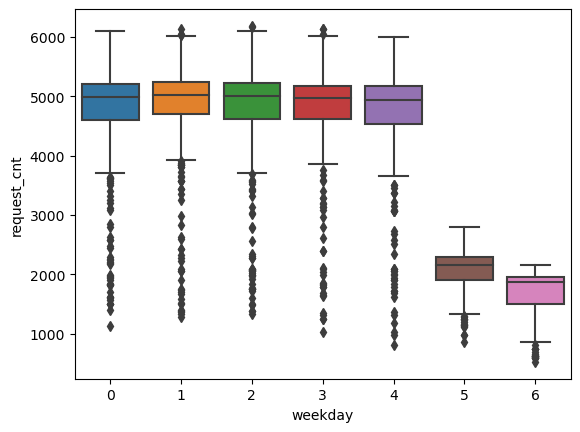

In [21]:
#접수 건수
sns.boxplot(x="weekday", y="request_cnt", data=df)
plt.show()

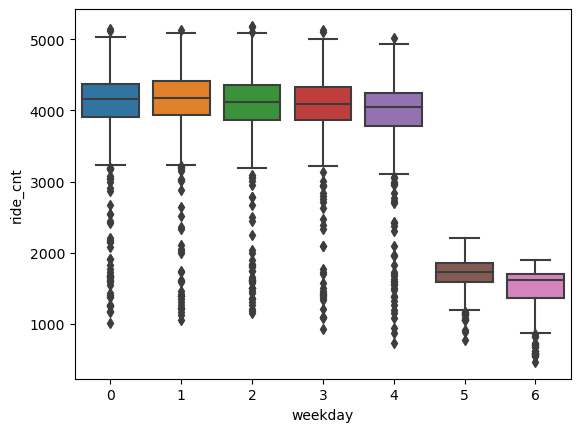

In [22]:
#탑승 건수 
sns.boxplot(x="weekday", y="ride_cnt", data=df)
plt.show()

* 대기시간

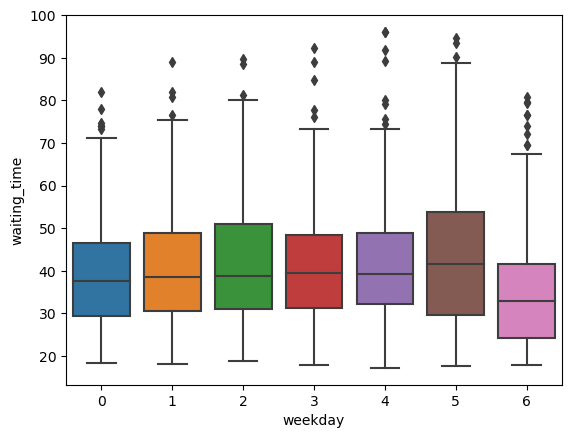

In [23]:
#대기시간
sns.boxplot(x="weekday", y="waiting_time", data=df)
plt.show()

* 운임

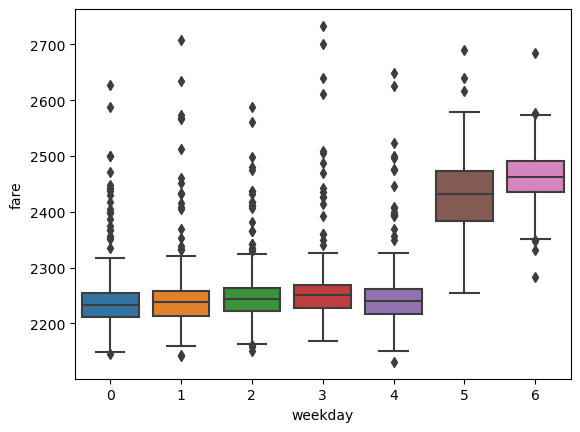

In [24]:
#운임
sns.boxplot(x="weekday", y="fare", data=df)
plt.show()

* 이동거리

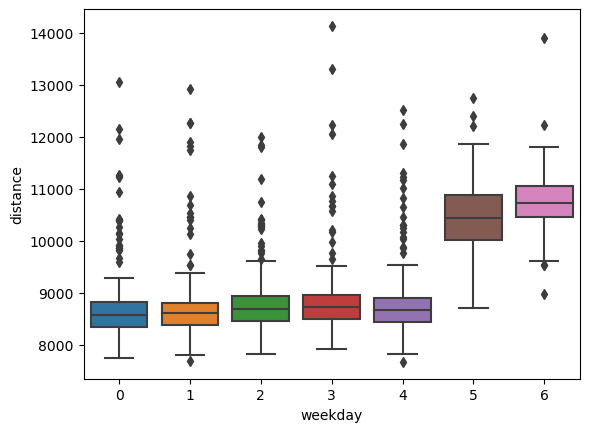

In [25]:
#이동거리
sns.boxplot(x="weekday", y="distance", data=df)
plt.show()

### (4) 월별 (boxplot활용)

* 차량 운행수

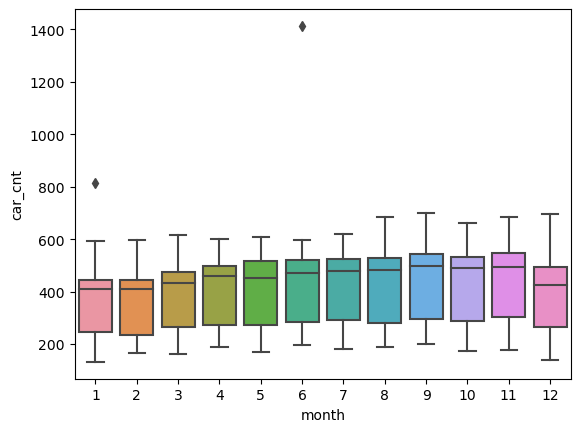

In [26]:
#차량운행수
sns.boxplot(x="month", y="car_cnt", data=df)
plt.show()

* 접수건, 탑승건

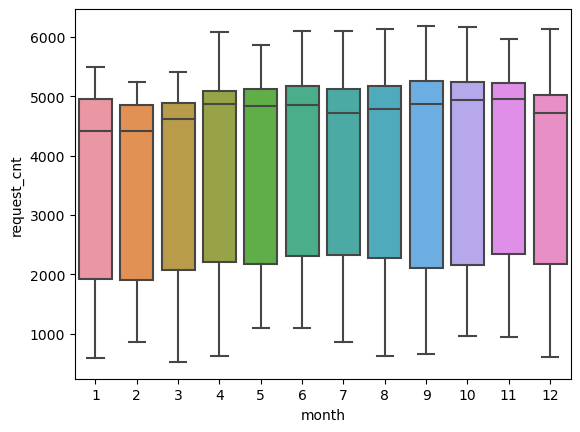

In [27]:
#접수건
sns.boxplot(x="month", y="request_cnt", data=df)
plt.show()

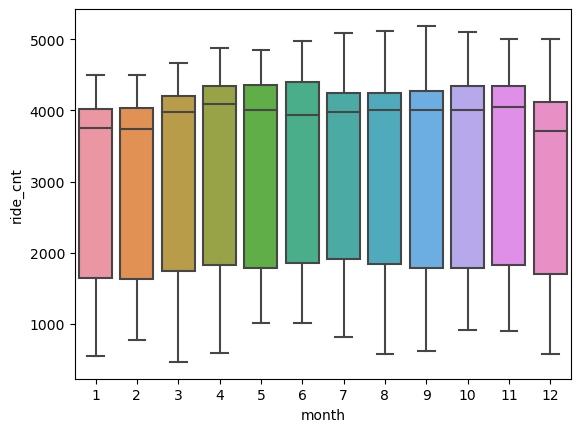

In [28]:
#탑승건
sns.boxplot(x="month", y="ride_cnt", data=df)
plt.show()

* 대기시간

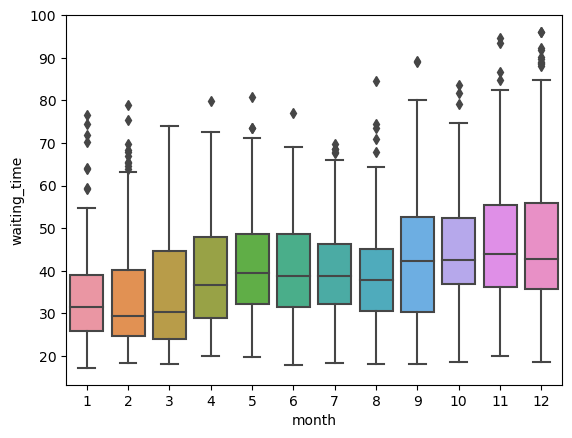

In [29]:
sns.boxplot(x="month", y="waiting_time", data=df)
plt.show()

* 운임

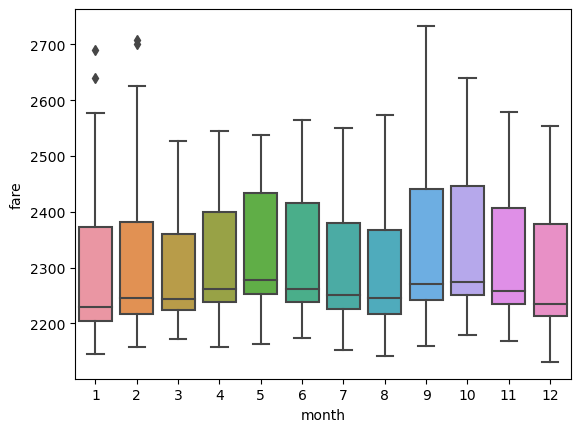

In [30]:
sns.boxplot(x="month", y="fare", data=df)
plt.show()

* 이동거리

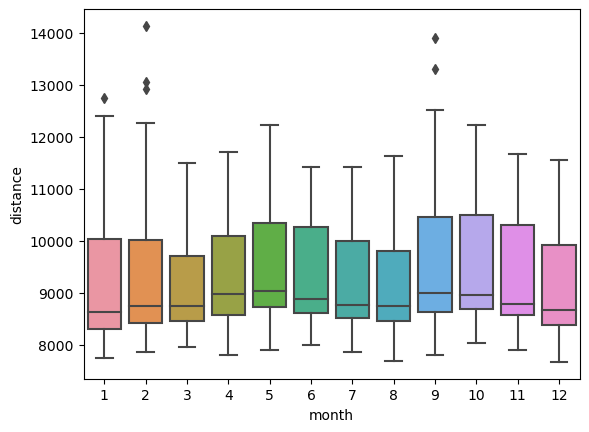

In [31]:
sns.boxplot(x="month", y="distance", data=df)
plt.show()

### (5) 연도별 (boxplot 활용)

* 차량 운행수

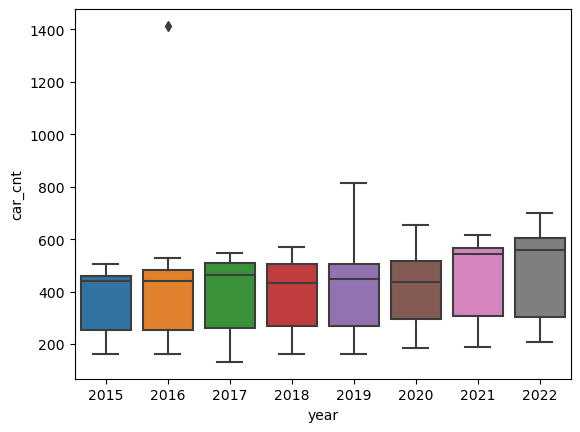

In [32]:
#차량운행수
sns.boxplot(x="year", y="car_cnt", data=df)
plt.show()

* 접수건, 탑승건

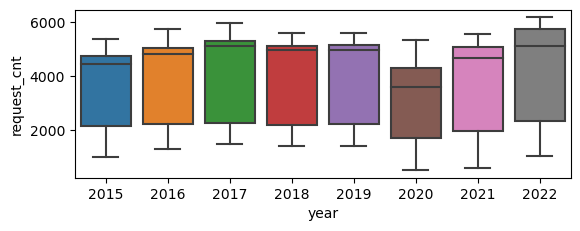

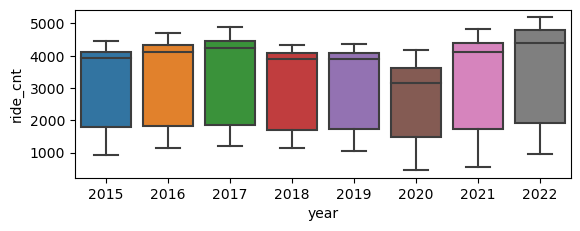

In [33]:
plt.subplot(2, 1, 1)
sns.boxplot(x="year", y="request_cnt", data=df)
plt.show()
plt.subplot(2, 1, 2)
sns.boxplot(x="year", y="ride_cnt", data=df)
plt.show()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [34]:
# 익일의 대기시간(waiting time)을 오늘의 데이터를 활용하여 예측 해야하는 대상(target)으로 설정
target='waiting_time'
#내일의 대기시간을 예측하는 것이므로, 하루 땡겨오기!
df['target']=df['waiting_time'].shift(-1)
df.head().T

Date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05
car_cnt,213.00,420.00,209.00,196.00,421.00
request_cnt,1023.00,3158.00,1648.00,1646.00,4250.00
ride_cnt,924.00,2839.00,1514.00,1526.00,3730.00
waiting_time,23.20,17.20,26.20,24.50,26.20
fare,2427.00,2216.00,2377.00,2431.00,2214.00
distance,10764.00,8611.00,10198.00,10955.00,8663.00
temp_max,-2.00,2.40,8.20,7.90,4.10
temp_min,-8.90,-9.20,0.20,-0.90,-7.40
rain(mm),0.00,0.00,0.00,0.00,3.40
humidity_max(%),63.00,73.00,89.00,95.00,98.00


### (2) 날씨 데이터 붙이기

In [ ]:
# 익일의 실제 날씨 데이터를 전일에 발표된 예보데이터로 판단

### (3) 새로운 feature를 생성
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [35]:
#계절
# 계절을 정의하는 함수
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

# 'month' 컬럼을 기반으로 'season' 컬럼 생성
df['season'] = df['month'].apply(get_season)

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [ ]:
# !pip install workalendar

* 간단 사용법

In [55]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
holiday=pd.DataFrame(cal.holidays(2022))
holiday.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2022-01-01,2022-01-31,2022-02-01,2022-02-02,2022-03-01,2022-05-05,2022-05-08,2022-06-06,2022-08-15,2022-09-09,2022-09-10,2022-09-11,2022-10-03,2022-10-09,2022-12-25
1,New year,Korean New Year's Day,Korean New Year's Day,Korean New Year's Day,Independence Day,Children's Day,Buddha's Birthday,Memorial Day,Liberation Day,Midautumn Festival,Midautumn Festival,Midautumn Festival,National Foundation Day,Hangul Day,Christmas Day


In [49]:
cal = SouthKorea()

# 2015년부터 2023년까지의 공휴일 정보를 저장할 빈 데이터프레임 생성
holiday= pd.DataFrame(columns=['Date'])

# 2015년부터 2023년까지의 각 연도에 대해 공휴일 정보를 가져와 데이터프레임에 추가
for year in range(2015, 2023):  # 2023년까지 포함
    holidays = cal.holidays(year)
    for date, holiday_name in holidays:
        holiday = holiday.append({'Date': date}, ignore_index=True)
holiday

C:\Users\user\AppData\Local\Temp\ipykernel_9644\2037330881.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday = holiday.append({'Date': date}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9644\2037330881.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday = holiday.append({'Date': date}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9644\2037330881.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday = holiday.append({'Date': date}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_9644\2037330881.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday = holida

,Date
0,2015-01-01
1,2015-02-18
2,2015-02-19
3,2015-02-20
4,2015-03-01
...,...
115,2022-09-10
116,2022-09-11
117,2022-10-03
118,2022-10-09


In [50]:
#제외되어있는 공휴일 정보 포함
holiday_plus=['20150929','20160206','20160210','20160413','20170130','20171006','20180507',
              '20180613','20180926','20190506','20200127','20200415','20220309','20220912','20221010']
holiday_plus=pd.to_datetime(holiday_plus)

holiday_plus

DatetimeIndex(['2015-09-29', '2016-02-06', '2016-02-10', '2016-04-13',
               '2017-01-30', '2017-10-06', '2018-05-07', '2018-06-13',
               '2018-09-26', '2019-05-06', '2020-01-27', '2020-04-15',
               '2022-03-09', '2022-09-12', '2022-10-10'],
              dtype='datetime64[ns]', freq=None)

In [51]:
holiday = pd.concat([holiday, pd.DataFrame({'Date': holiday_plus})], axis=0, ignore_index=True)

In [52]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    135 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가
    * 대체공휴일, 선거일 등등

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0

In [54]:
# holiday 데이터프레임에서 'Date' 컬럼을 날짜 형식으로 변환
holiday['Date'] = pd.to_datetime(holiday['Date'])

# 초기값 0
df['is_holiday'] = 0

# df의 인덱스를 반복하면서 'Date' 컬럼과 비교하여 'is_holiday' 값을 설정
for date in df.index:
    if date in holiday['Date'].values:
        df.at[date, 'is_holiday'] = 1

df['is_holiday'].value_counts()

0    2788
1     134
Name: is_holiday, dtype: int64

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2922 entries, 2015-01-01 to 2022-12-31
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_cnt          2922 non-null   int64  
 1   request_cnt      2922 non-null   int64  
 2   ride_cnt         2922 non-null   int64  
 3   waiting_time     2922 non-null   float64
 4   fare             2922 non-null   int64  
 5   distance         2922 non-null   int64  
 6   temp_max         2921 non-null   float64
 7   temp_min         2921 non-null   float64
 8   rain(mm)         2921 non-null   float64
 9   humidity_max(%)  2921 non-null   float64
 10  humidity_min(%)  2921 non-null   float64
 11  sunshine(MJ/m2)  2921 non-null   float64
 12  target           2921 non-null   float64
 13  weekday          2922 non-null   int64  
 14  month            2922 non-null   int64  
 15  week             2922 non-null   int64  
 16  year             2922 non-null   int64  
 

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [98]:
df['wait_time_mean'] = df['waiting_time'].rolling(window=7).mean()

# 결과 확인
print(df[['waiting_time', 'wait_time_mean']])

            waiting_time  wait_time_mean
Date                                    
2015-01-01          23.2             NaN
2015-01-02          17.2             NaN
2015-01-03          26.2             NaN
2015-01-04          24.5             NaN
2015-01-05          26.2             NaN
...                  ...             ...
2022-12-27          44.4       42.771429
2022-12-28          44.8       43.514286
2022-12-29          52.5       42.957143
2022-12-30          38.3       41.042857
2022-12-31          33.7       41.657143

[2922 rows x 2 columns]


#### 4) 탑승률

In [99]:
df['ride_pro'] = round(df['ride_cnt']/df['request_cnt']*100,2)
df['ride_pro']

Date
2015-01-01    90.32
2015-01-02    89.90
2015-01-03    91.87
2015-01-04    92.71
2015-01-05    87.76
              ...  
2022-12-27    82.59
2022-12-28    82.21
2022-12-29    80.90
2022-12-30    79.35
2022-12-31    83.34
Name: ride_pro, Length: 2922, dtype: float64

In [100]:
df.T

Date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
car_cnt,213,420,209,196,421,417,410,419,424,215,...,625,607,308,217,603,669,607,581,600,263
request_cnt,1023,3158,1648,1646,4250,3991,4085,4030,4167,1916,...,5899,5570,2279,1945,5555,5635,5654,5250,5293,2167
ride_cnt,924,2839,1514,1526,3730,3633,3676,3728,3813,1645,...,4716,4361,1910,1588,4605,4654,4648,4247,4200,1806
waiting_time,23.2,17.2,26.2,24.5,26.2,23.6,24.7,21.2,21.8,41.2,...,56.4,51.7,29.4,38.7,39.2,44.4,44.8,52.5,38.3,33.7
fare,2427,2216,2377,2431,2214,2211,2230,2231,2215,2447,...,2188,2159,2367,2416,2163,2198,2161,2229,2183,2318
distance,10764,8611,10198,10955,8663,8545,8646,8683,8506,11123,...,8051,8003,9806,10212,7889,8178,7882,8433,8155,9435
temp_max,-2.0,2.4,8.2,7.9,4.1,-1.0,-0.2,3.2,4.3,2.3,...,-9.2,-2.1,-0.2,1.5,3.0,-0.3,1.7,2.1,-4.4,NaN
temp_min,-8.9,-9.2,0.2,-0.9,-7.4,-8.8,-9.2,-6.8,-5.5,-4.0,...,-13.7,-13.5,-9.5,-7.9,-7.3,-5.4,-7.8,-4.0,-4.4,NaN
rain(mm),0.0,0.0,0.0,0.0,3.4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,NaN
humidity_max(%),63.0,73.0,89.0,95.0,98.0,42.0,62.0,78.0,81.0,83.0,...,65.0,69.0,81.0,85.0,86.0,92.0,71.0,87.0,66.0,NaN


In [101]:
df.loc['2022-09-25']

car_cnt                  233
request_cnt             1890
ride_cnt                1613
waiting_time            35.4
fare                    2505
distance               11060
temp_max                25.3
temp_min                14.9
rain(mm)                 0.0
humidity_max(%)         82.0
humidity_min(%)         32.0
sunshine(MJ/m2)        18.48
target                  45.5
weekday                    6
month                      9
week                      38
year                    2022
season                autumn
is_holiday                 0
ride_pro               85.34
humidity                57.0
temp                    20.1
is_rainy                   0
wait_time_mean     43.528571
Name: 2022-09-25 00:00:00, dtype: object

In [83]:
#습도 평균
df['humidity']=df[['humidity_max(%)','humidity_min(%)']].mean(axis=1)
df['humidity'].loc['2022-09-25']

57.0

In [86]:
#온도 평균
df['temp']=df[['temp_max','temp_min']].mean(axis=1)
df['temp'].loc['2022-07-25']

28.599999999999998

In [95]:
#비 유무 기준 3mm로 지정
selected_rows = df.loc[df['rain(mm)'] >= 3]
selected_rows[['humidity','temp','rain(mm)']]

,humidity,temp,rain(mm)
Date,,,
2015-01-05,63.5,-1.65,3.4
2015-02-15,76.5,6.35,9.5
2015-02-20,73.5,5.75,6.5
2015-02-21,73.5,3.30,4.0
2015-03-02,61.0,3.15,5.5
...,...,...,...
2022-11-12,84.0,13.20,19.4
2022-11-27,67.0,11.25,10.0
2022-11-28,70.0,7.10,13.3


* 3mm이하의 날씨의 경우 일기예보에 비 관련 과거 기사들이 많지않음
* 3mm이상일때 유의미한 비가 온것으로 예상됨

In [96]:
#비 유무
df['is_rainy'] = df['rain(mm)'].apply(lambda x: 1 if x > 3 else 0)

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장
        * 저장파일이름 : data1.pkl

In [97]:
import joblib

# 데이터프레임을 저장할 경로 및 파일 이름
file_path = 'data1.pkl'

# 데이터프레임 저장
joblib.dump(df, file_path)

['data1.pkl']